# PyESAPI: Getting Started
*By Michael.Folkerts@varian.com*

We assume `pip install git+https://github.com/VarianAPIs/PyESAPI` has already been executed in your conda3 environment.
## Import PyESAPI
* Create one instance of the eclipse scripting application
* Set the script name for logging purposes to "python_demo"
* Regester the application disposal fumctopm at exit (avoids unexpected exit/crash of app instance)

In [1]:
import pyesapi
import atexit
app = pyesapi.CustomScriptExecutable.CreateApplication('python_demo')
atexit.register(app.Dispose);

## Find a Patient
* List patient Ids
* Open a patient
* Print patient info
* Python 3.6 f-string sugar

In [2]:
for pat_sum in app.PatientSummaries:
    print(pat_sum.Id, pat_sum.LastName, pat_sum.FirstName)

007 Doe John
CSI_01 Demo CSI_01
EC-034 Brain mets Multiple
Eclipse 07 HyperArc Brain
Eclipse 11 MCO Brain
Eclipse 06 MCO Head_Neck
zz_cerv_nod_5 zz_cerv_nod_5 
RapidPlan-01 RapidPlan Prostate T1cN0M0 PSA21.6 G7
RapidPlan-03 RapidPlan HN 3 PTV
PH PHA QUA
Civco_couch Civco Couch
Encompass Encompass SRS
Sinmed Sinmed Couch
VSS 06 Brain Mets 4 mets, CT-MR
VSS 07 Brain Mets 12 Met, CT-MR
Eclipse-03 Head and Neck Two PTV's
Eclipse-04 Lung Right Upper
RapidPlan-02 RapidPlan ProstateNodes T2cN0M0
RapidPlan-04 RapidPlan HN 3 PTV
RapidPlan-06 RapidPlan Lung LUL
Registration 2 Registration Brain CT-MR
Registration 5 PET CT to Plan CT Deformable
Registration 6 Prostate Target Registration Error
SmartSeg 1 Prostate T2 N0 M0 PSA8 GS8
SmartSeg 2 Tonsil T3 N2b M0 right
SmartSeg 3 Nasopharynx T2 N2 M0 right
SmartSeg 4 Rectum T3 N1 M0
Eclipse-01 4D Lung PET CT
Registration 1 Head and Neck CT and CBCT
Registration 3 HeadNeck CT MRI
VSS 01 Spine T6 and T11, CT-MR
VSS 02 Lung RT and LT Lesions, CT
VSS 04 B

In [3]:
patient = app.OpenPatientById('RapidPlan-01')

In [4]:
print('Name: {patient.FirstName}, LastName: {patient.LastName}'.format(**locals()))

Name: Prostate T1cN0M0 PSA21.6 G7, LastName: RapidPlan


In [5]:
print(f'Name: {patient.FirstName}, LastName: {patient.LastName}')

Name: Prostate T1cN0M0 PSA21.6 G7, LastName: RapidPlan


## A little about Lots
* Create an array with pythonnet collection iterator
* Demo the PyESAPI Lot
  * Indexing
  * Constructor Shortcuts
  * Constructor Select
  * Lot.FirstOrDefault

In [6]:
[c.Id for c in patient.Courses] # python list comprehension on pythonnet collection iterator

['C1']

### <a href="https://www.google.com/search?q=define+lot">Lot</a>
*noun*  
1.  
*informal*  
a particular group, collection, or set of people or things.  
*"it's just one lot of rich people stealing from another"*

In [7]:
patient.CoursesLot() # "Lot" a custom PyESAPI collection wrapper class

In [8]:
patient.CoursesLot()[0].Id # Indexable after construction

'C1'

In [9]:
patient.CoursesLot(0).Id # Indexable at construction

'C1'

In [10]:
patient.CoursesLot('C1').Id # passing string will match Id

'C1'

In [11]:
patient.CoursesLot(lambda c: c.Id == 'C1').Id # passing function acts like "first or default"

'C1'

In [12]:
patient.CoursesLot().FirstOrDefault(lambda c: c.Id == 'C1').Id

'C1'

## Open a Plan
* Print plan info
* Print structure info
* Print beam info

In [13]:
plan = patient.CoursesLot('C1').PlanSetupsLot(0)

In [14]:
print(f'Plan Id: {plan.Id}')
print(f'Dose Per Fx: {plan.PrescribedDosePerFraction}')
print(f'Number of Fx: {plan.NumberOfFractions}')

Plan Id: RA Calc
Dose Per Fx: 2.000 Gy
Number of Fx: 39


In [15]:
print(f'StructureID,TYPE,VOLUME')
for structure in plan.StructureSet.Structures:
    print(f'{structure.Id},{structure.DicomType},{structure.Volume:.2f}')

StructureID,TYPE,VOLUME
External,EXTERNAL,39442.98
Bladder,ORGAN,387.96
CTV Prostate,CTV,35.39
z CouchInterior,SUPPORT,14789.42
FemoralHead_L,ORGAN,166.43
Bowel,ORGAN,589.58
PTV,PTV,100.97
FemoralHead_R,ORGAN,168.58
Rectum,ORGAN,69.59
z CouchSurface,SUPPORT,2723.04


In [16]:
print(f'BeamID,SSD,Mu,StartAngle')
for beam in plan.Beams:
    print(f'{beam.Id},{beam.SSD:.2f},{beam.Meterset.Value:.2f},{beam.ControlPoints[0].GantryAngle}')

BeamID,SSD,Mu,StartAngle
ARC1-CW,886.17,326.31,181.0
ARC2-CCW,886.20,378.94,179.0


## Plotting
* Get CT Image as 3D Numpy Array
* Print CT properties
* Plot a CT slice
* Plot contour on CT slice
* Crop and Zoom
* Get dose at CT resolution
* Plot Dose slice
* Get structure mask
* Plot dose in structure only
* Plot dose on CT slice with contour
 * *Bonus: Interactive slice viewer*
* Get and plot DVH
* **Extra Credit:** Overlay all dose above a given value
* **Extra Credit:** Compute DVH using structure masks

In [17]:
ct = plan.StructureSet.Image  # just a shortcut
ct_image = plan.StructureSet.Image.np_array_like() # an actual numpy array

In [18]:
type(ct_image)

numpy.ndarray

In [19]:
print(ct.XSize, ct.YSize, ct.ZSize)
print(ct_image.shape)

512 512 191
(512, 512, 191)


In [20]:
import matplotlib.pyplot as plt

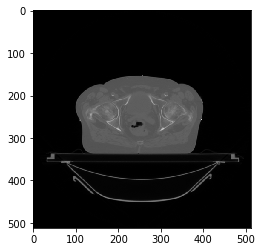

In [21]:
slice_num = 75
plt.imshow(ct_image[:,:,slice_num].T, cmap='gray')
plt.show()

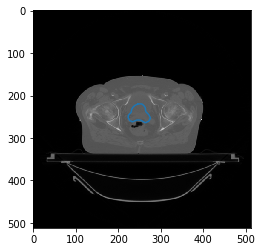

In [22]:
ptv_structure = plan.StructureSet.StructuresLot('PTV')

plt.imshow(ct_image[:,:,slice_num].T, cmap='gray')
contours = ptv_structure.GetContoursOnImagePlane(slice_num)
for pt_list in contours:
    plt.plot([(pt.x-ct.Origin.x)/ct.XRes for pt in pt_list],[(pt.y-ct.Origin.y)/ct.YRes for pt in pt_list])
plt.show()

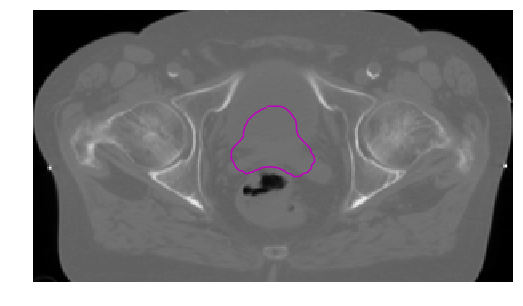

In [23]:
plt.figure(figsize=(10,5))
plt.imshow(ct_image[100:400,160:330,slice_num].T, cmap='gray')

for pt_list in ptv_structure.GetContoursOnImagePlane(slice_num):
    plt.plot([(pt.x-ct.Origin.x)/ct.XRes - 100 for pt in pt_list],
             [(pt.y-ct.Origin.y)/ct.YRes - 160 for pt in pt_list],'m')

plt.axis('off')  # turn of axis numbers
plt.show()

In [24]:
dose = plan.Dose.np_array_like(plan.StructureSet.Image) # creating dose at *CT resolution* takes about 50 seconds

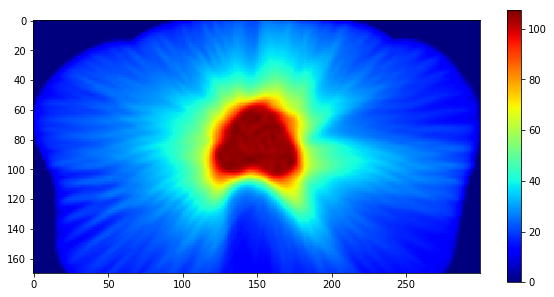

In [25]:
roi_slice=(slice(100,400),slice(160,330),slice_num)

plt.figure(figsize=(10,5))
plt.imshow(dose[roi_slice].T,cmap='jet')
plt.colorbar()
plt.show()

In [26]:
ptv_structure_mask = plan.StructureSet.StructuresLot('PTV').np_mask_like(plan.StructureSet.Image)  # takes about 20 sec

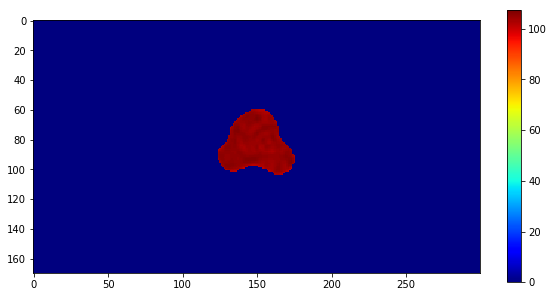

In [27]:
dose_in_ptv = dose*ptv_structure_mask

plt.figure(figsize=(10,5))
plt.imshow(dose_in_ptv[roi_slice].T, cmap='jet')
plt.colorbar()
plt.show()

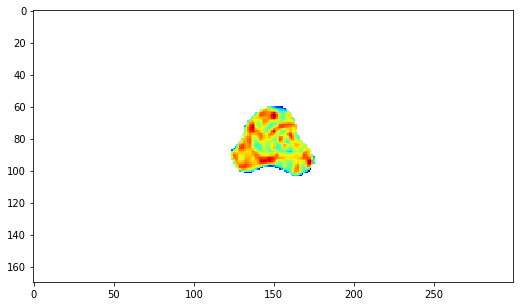

In [28]:
import numpy as np
non_zero_dose_ptv = np.ma.masked_where(dose_in_ptv==0,dose_in_ptv)

plt.figure(figsize=(10,5))
plt.imshow(non_zero_dose_ptv[roi_slice].T, cmap='jet')
plt.show()

In [29]:
def plt_contour_at_slice(structure, roi, style):
    for pt_list in structure.GetContoursOnImagePlane(roi[2]):
        plt.plot([(pt.x-ct.Origin.x)/ct.XRes - roi[0].start for pt in pt_list],
                 [(pt.y-ct.Origin.y)/ct.YRes - roi[1].start for pt in pt_list],style)

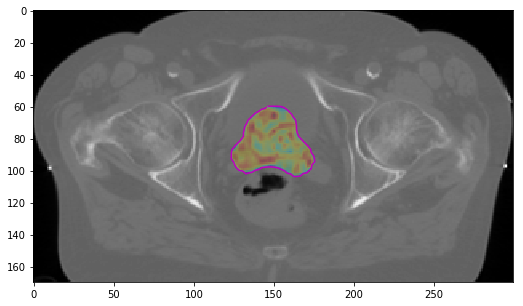

In [30]:
plt.figure(figsize=(10,5))
plt.imshow(ct_image[roi_slice].T, cmap='gray')
plt.imshow(non_zero_dose_ptv[roi_slice].T, cmap='jet',alpha=.25)
plt_contour_at_slice(ptv_structure, roi_slice,'m')
plt.show()

## Bonus
* Interactive slice viewer

In [31]:
from ipywidgets import interactive, widgets

def slice_plot_function(slider_num):
    plt.figure(figsize=(10,5))
    plt.imshow(ct_image[roi_slice[0],roi_slice[1],slider_num].T, cmap='gray', vmax=2000)
    plt.imshow(dose[roi_slice[0],roi_slice[1],slider_num].T, cmap='jet', alpha=.3, vmax=110)
    cb=plt.colorbar()
    cb.set_alpha(1.0)  # so colorbar is not transparent
    cb.draw_all()
    
    roi_slider = (roi_slice[0],roi_slice[1],slider_num)
    plt_contour_at_slice(ptv_structure,roi_slider,'m')
    plt_contour_at_slice(plan.StructureSet.StructuresLot('Bladder'),roi_slider,'b')
    plt_contour_at_slice(plan.StructureSet.StructuresLot('Rectum'),roi_slider, 'g')
    
    plt.show()

int_slider = widgets.IntSlider(
    value=slice_num,
    min=0,
    max=ct_image.shape[2]-1,
    step=1,
    description='Slice Number',
    continuous_update=False,
)
    
interactive(slice_plot_function, slider_num=int_slider)

interactive(children=(IntSlider(value=75, continuous_update=False, description='Slice Number', max=190), Output()), _dom_classes=('widget-interact',))

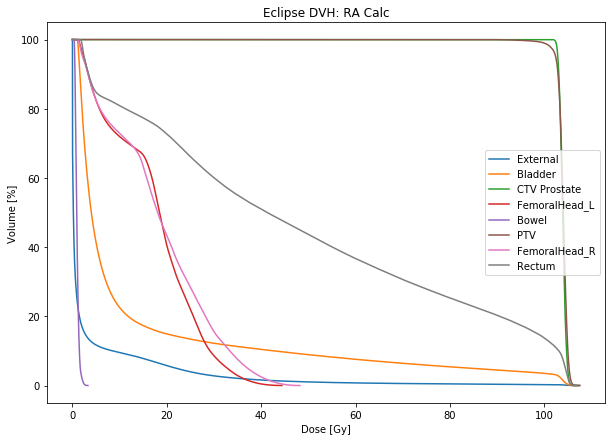

In [32]:
plt.figure(figsize=(10,7))
for structure in plan.StructureSet.Structures:
    dvh = plan.GetDVHCumulativeData(
        structure,
        pyesapi.DoseValuePresentation.Relative,
        pyesapi.VolumePresentation.Relative,
        .01
    )
    if dvh is not None:
        dose_x = [p.DoseValue.Dose for p in dvh.CurveData]
        volume_y = [p.Volume for p in dvh.CurveData]
        plt.plot(dose_x, volume_y, label=structure.Id)

plt.legend(loc=0)
plt.title(f'Eclipse DVH: {plan.Id}')
plt.ylabel('Volume [%]')
plt.xlabel('Dose [Gy]')
plt.show()